In [14]:
!unrar x -Y "Resnet D and W and P.rar" "Dataset/SDNET2018"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal

Cannot open Resnet D and W and P.rar
No such file or directory
No files to extract


In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from tensorflow.keras.preprocessing.image import load_img
#from keras import Model
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ( Conv2DTranspose, concatenate,
    Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D,
    Flatten, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, add)
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
# from keras.engine import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
# from keras.engine.topology import get_source_inputs
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-11-16 11:20:12.480652: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 11:20:12.532103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 11:20:13.520079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [2]:
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
#from keras import optimizers
#from keras.layers.normalization import BatchNormalization
#from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#from keras.layers import GaussianNoise
#from keras.utils.vis_utils import plot_model
#from keras.optimizers import Adam
from datetime import datetime
import tensorflow as tf

from sklearn.model_selection import StratifiedShuffleSplit
import shutil
import argparse
import os
import pandas  as pd
import numpy as np

In [3]:
#Preprossing the data
f_dic={'file_name':[],'Dir':[],'label':[],'file_data':[]}
types=['Negative','Positive']
for Ftype in types:
    for file in os.listdir("METU/" + Ftype):
            if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".PNG") or file.endswith(".JPG") or file.endswith(".JPEG"):
                f_dic['file_name'].append(file)
                image=tf.keras.preprocessing.image.load_img("METU/"+Ftype+"/"+file, color_mode='rgb', target_size= (224, 224))
                f_dic['file_data'].append(np.array(image))
                f_dic['Dir'].append("2class-classificationDatasetMETU"+Ftype+"/"+file)
                f_dic['label'].append(Ftype)

In [4]:
import tensorflow as tf
tf.__version__
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
DEVICE = "/Gpu:0"  # /cpu:0 or /gpu:0

Num GPUs Available:  1


In [5]:
df_Covid = pd.DataFrame(data=f_dic)
df_Covid.to_csv(r'./Models/METU/inception/\2class-classification.csv')
print(len(df_Covid))
print(df_Covid.label.unique())
df_Covid.head()

40000
['Negative' 'Positive']


,file_name,Dir,label,file_data
0,00062.jpg,2class-classificationDatasetMETUNegative/00062...,Negative,"[[[187, 184, 169], [189, 186, 171], [192, 189,..."
1,00001.jpg,2class-classificationDatasetMETUNegative/00001...,Negative,"[[[178, 175, 170], [173, 170, 165], [166, 163,..."
2,00063.jpg,2class-classificationDatasetMETUNegative/00063...,Negative,"[[[209, 204, 198], [208, 203, 197], [208, 203,..."
3,00002.jpg,2class-classificationDatasetMETUNegative/00002...,Negative,"[[[209, 199, 189], [208, 198, 188], [205, 195,..."
4,00064.jpg,2class-classificationDatasetMETUNegative/00064...,Negative,"[[[181, 178, 173], [183, 180, 175], [185, 182,..."


(-1.1, 1.1, -1.1, 1.1)

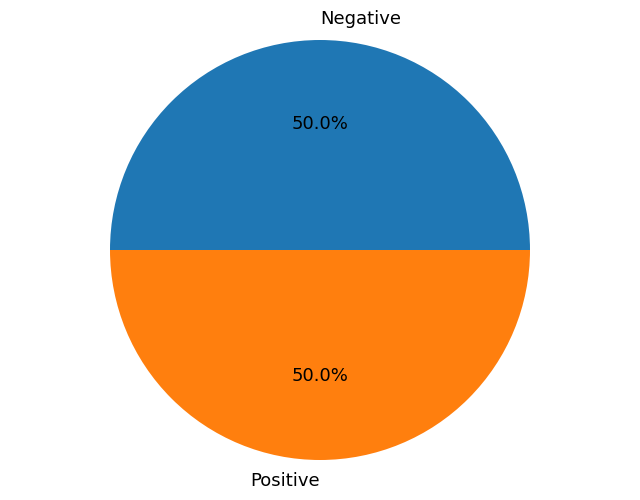

In [6]:
df_Covid['label'].value_counts().plot(kind='pie',
                                  figsize=(8,6),
                                  fontsize=13,
                                  autopct='%1.1f%%',
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal')

In [7]:

# Convert features and corresponding classification labels into numpy arrays
filesFull= np.array(df_Covid.file_data.tolist())
labelsFull = np.array(df_Covid.label.tolist())

# Encode the classification labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
labels = to_categorical(le.fit_transform(labelsFull))
# shuffle and split - stratified because of label imbalance

splitseed = 2
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=splitseed)
for train_index, test_index in sss.split(filesFull, labelsFull):
    X_train, X_test = filesFull[train_index], filesFull[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


print('Train set size: {0}'.format(X_train.shape[0]))
print('Test set size: {0}'.format(X_test.shape[0]))
print('labels set size: {0}'.format(y_test.shape[1]))

Train set size: 32000
Test set size: 8000
labels set size: 2


In [8]:
# save the train and test subsets for future use
file_path = "Models/METU/filedata/"
np.save(file_path +"X_train", X_train)
np.save(file_path +"X_test", X_test)
np.save(file_path +"y_train", y_train)
np.save(file_path +"y_test", y_test)

print("Data  saved")

Data  saved


In [3]:
# Load data
file_path = "Models/METU/filedata/"

X_train = np.load(file_path + "X_train.npy")
X_test = np.load(file_path + "X_test.npy")
y_train = np.load(file_path + "y_train.npy")
y_test = np.load(file_path + "y_test.npy")

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32000, 224, 224, 3)
(8000, 224, 224, 3)
(32000, 2)
(8000, 2)


In [4]:
image_generator = ImageDataGenerator(validation_split=0.2,
                                     rescale = 1./255)

train_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory='METU',
                                                 shuffle=True,
                                                 target_size=(224, 224),
                                                 subset="training",
                                                 #class_mode='categorical'
                                                 class_mode='binary')

test_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory='METU',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 subset="validation",
                                                 #class_mode='categorical'
                                                class_mode='binary')

Found 32000 images belonging to 3 classes.
Found 8000 images belonging to 3 classes.


In [5]:
# Set some parameters
im_width = 224
im_height = 224
border = 5

In [6]:
import numpy as np

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Load InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False

# Add custom layers on top of the InceptionV3 model
x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units=2, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=inception_model.input, outputs=output)

# Print model summary
model.summary()

2023-11-16 11:20:31.255279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:b1:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [8]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=["accuracy"])

In [9]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('Models/METU/inception/inception.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
from sklearn.metrics import confusion_matrix
# fit the model
# Run the cell. It will take some time to execute
history_inception = model.fit(
  X_train, y_train,
  validation_data=(X_test, y_test),
  epochs=50,
  steps_per_epoch=len(train_data),
  callbacks=callbacks,\
  validation_steps=len(test_data)
)

Epoch 1/50


2023-11-16 11:20:58.919031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-16 11:20:59.286467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-16 11:20:59.923868: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2201845d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 11:20:59.923891: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-16 11:20:59.935943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 11:21:00.081147: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

1000/1000 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.9603
Epoch 1: val_loss improved from inf to 0.06787, saving model to Models/METU/inception/inception.h5
1000/1000 [==============================] - 33s 27ms/step - loss: 0.2944 - accuracy: 0.9603 - val_loss: 0.0679 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 2/50
 999/1000 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9734
Epoch 2: val_loss improved from 0.06787 to 0.05689, saving model to Models/METU/inception/inception.h5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0822 - accuracy: 0.9734 - val_loss: 0.0569 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 3/50
 999/1000 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9777
Epoch 3: val_loss improved from 0.05689 to 0.04545, saving model to Models/METU/inception/inception.h5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0683 - accuracy: 0.9778 - val_loss: 0.0455 - va

In [11]:
#  save to csv:
import sklearn.metrics as metrics
hist_df = pd.DataFrame(history_inception.history)
hist_df.to_csv(r'Models/METU/inception/history_inception.csv')

In [12]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(X_test)
conf =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

250/250 [==============================] - 5s 17ms/step


In [16]:

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

250/250 [==============================] - 4s 18ms/step - loss: 0.0307 - accuracy: 0.9895
Accuracy =  98.94999861717224 %


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Assuming you have the predicted labels and true labels
y_pred = model.predict(X_test)  # Replace with your predicted labels
y_true = y_test.argmax(axis=1)  # Replace with your true labels

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred.argmax(axis=1))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred.argmax(axis=1))

# Calculate precision
precision = precision_score(y_true, y_pred.argmax(axis=1))

# Calculate recall
recall = recall_score(y_true, y_pred.argmax(axis=1))

# Calculate F1-score
f1 = f1_score(y_true, y_pred.argmax(axis=1))

# Calculate ROC curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
auc_roc = auc(fpr, tpr)

# Print the results
print(f"Confusion Matrix:\n{confusion}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

250/250 [==============================] - 4s 17ms/step
Confusion Matrix:
[[3959   41]
 [  43 3957]]
Accuracy: 0.9895
Precision: 0.9897
Recall: 0.9892
F1-score: 0.9895
AUC-ROC: 0.9993


In [17]:

# Extract values from the confusion matrix
TP = conf[1, 1]
TN = conf[0, 0]
FP = conf[0, 1]
FN = conf[1, 0]

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy:", accuracy)

# Sensitivity or Recall
recall = TP / (TP + FN)
print("Sensitivity/Recall:", recall)

# Specificity
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# Precision
precision = TP / (TP + FP)
print("Precision:", precision)

# F1 Score
f1 = 2 * TP / (2 * TP + FP + FN)
print("F1 Score:", f1)

# Matthews correlation coefficient (MCC)
num = (TP * TN) - (FP * FN)
den = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
mcc = num / den if den != 0 else 0
print("MCC:", mcc)

Accuracy: 0.9895
Sensitivity/Recall: 0.98925
Specificity: 0.98975
Precision: 0.9897448724362181
F1 Score: 0.9894973743435859
MCC: 0.979000122375023


250/250 [==============================] - 4s 17ms/step


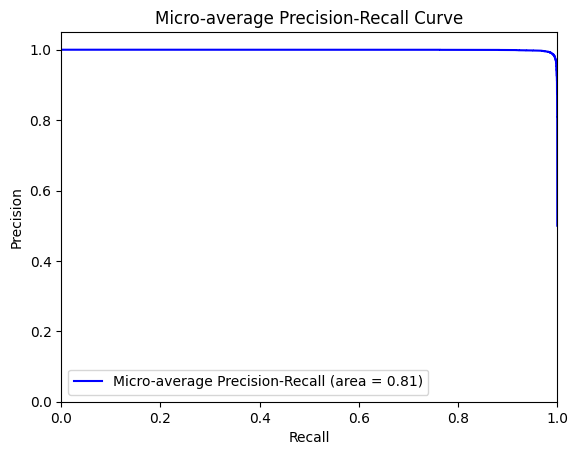

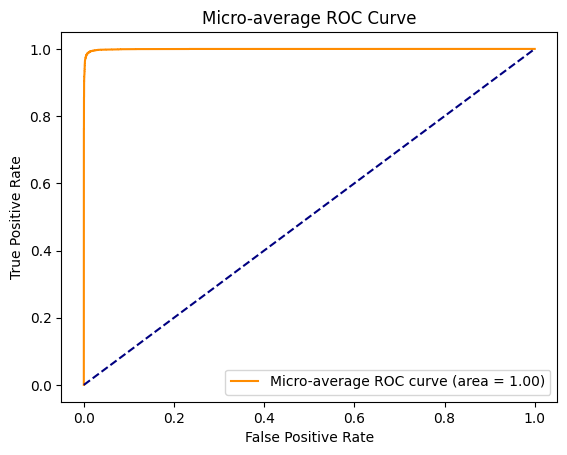

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from itertools import cycle

# Assuming you have the predicted probabilities for each class
y_pred_prob = model.predict(X_test)  # Replace with your predicted probabilities
y_true = y_test  # Replace with your true labels

# Calculate precision and recall for each class
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred_prob.ravel())

# Calculate micro-average precision and recall
micro_precision = np.average(precision)
micro_recall = np.average(recall)

# Calculate micro-average ROC curve
fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_prob.ravel())
micro_auc = auc(fpr, tpr)

# Plot micro-average precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', label='Micro-average Precision-Recall (area = {0:0.2f})'
                                               ''.format(micro_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Micro-average Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Plot micro-average ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Micro-average ROC curve (area = {0:0.2f})'
                                              ''.format(micro_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

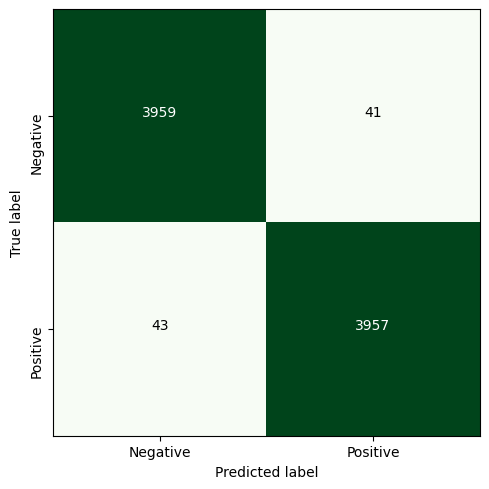

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
classes = ["Negative", "Positive"]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
#plt.title("Negative", "Positive")
#plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes,rotation=90)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Models/METU/inception/COnMatIncV3inception.jpg', bbox_inches='tight')

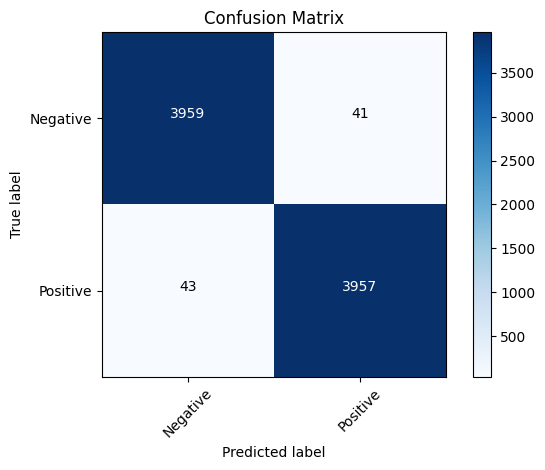

In [15]:
classes = ["Negative", "Positive"]

# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Fill confusion matrix cells with values
thresh = conf.max() / 2.
for i, j in np.ndindex(conf.shape):
    plt.text(j, i, format(conf[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

250/250 [==============================] - 4s 17ms/step


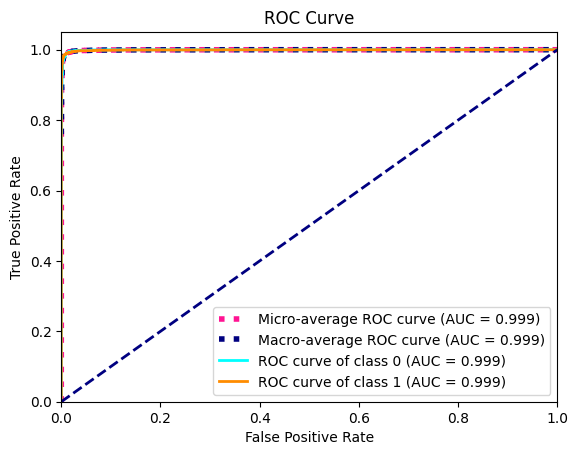

<Figure size 640x480 with 0 Axes>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Assuming you have the predicted probabilities for each class
y_pred_prob = model.predict(X_test)  # Replace with your predicted probabilities
y_true = y_test  # Replace with your true labels

# Calculate the number of classes
num_classes = y_true.shape[1]

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_prob.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
fpr_macro = dict()
tpr_macro = dict()
auc_macro = dict()
for i in range(num_classes):
    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

# Plot ROC curve for each class
plt.figure()

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (AUC = {0:0.3f})'.format(auc_micro))

# Plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
mean_tpr /= num_classes
fpr_macro["average"] = all_fpr
tpr_macro["average"] = mean_tpr
auc_macro["average"] = auc(fpr_macro["average"], tpr_macro["average"])
plt.plot(fpr_macro["average"], tpr_macro["average"], color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (AUC = {0:0.3f})'.format(auc_macro["average"]))

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr_macro[i], tpr_macro[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.3f})'.format(i, auc_macro[i]))

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

# Set the plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
plt.savefig('Models/METU/inception/2ROC_imginception.jpg',bbox_inches='tight')

250/250 [==============================] - 4s 17ms/step


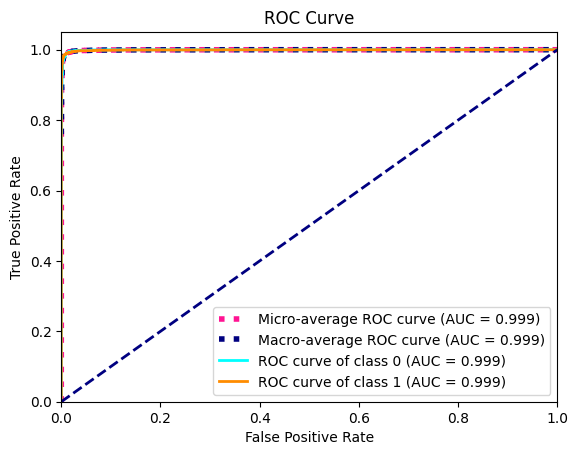

<Figure size 640x480 with 0 Axes>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Assuming you have the predicted probabilities for each class
y_pred_prob = model.predict(X_test)  # Replace with your predicted probabilities
y_true = y_test  # Replace with your true labels

# Calculate the number of classes
num_classes = y_true.shape[1]

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_prob.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
fpr_macro = dict()
tpr_macro = dict()
auc_macro = dict()
for i in range(num_classes):
    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

# Plot ROC curve for each class
plt.figure()

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (AUC = {0:0.3f})'.format(auc_micro))

# Plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
mean_tpr /= num_classes
fpr_macro["average"] = all_fpr
tpr_macro["average"] = mean_tpr
auc_macro["average"] = auc(fpr_macro["average"], tpr_macro["average"])
plt.plot(fpr_macro["average"], tpr_macro["average"], color='navy', linestyle=':', linewidth=4,
         label='Macro-average ROC curve (AUC = {0:0.3f})'.format(auc_macro["average"]))

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr_macro[i], tpr_macro[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.3f})'.format(i, auc_macro[i]))

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

# Set the plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
plt.savefig('Models/METU/inception/2ROC_imginception.jpg',bbox_inches='tight')

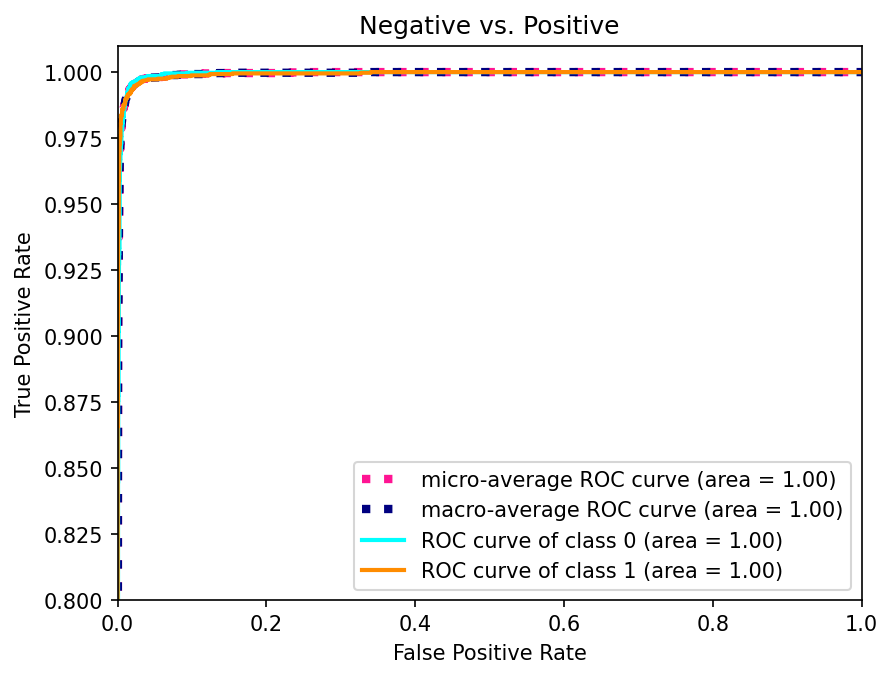

<Figure size 640x480 with 0 Axes>

In [25]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()
plt.figure(dpi=150)
lw = 2
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(len(classes)), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

#plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.8, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Negative vs. Positive")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Models/METU/inception/1ROC_imginception.jpg',bbox_inches='tight')

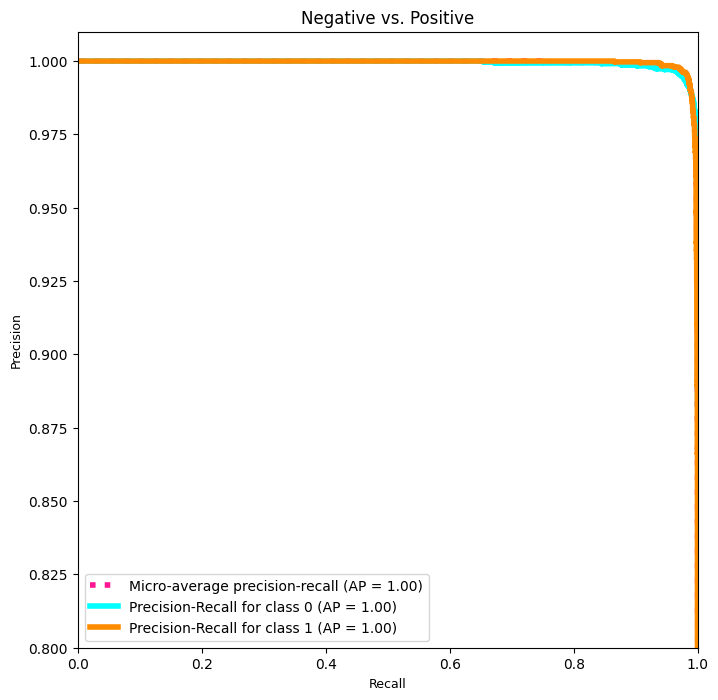

In [24]:
#PRINT THE P-R CURVE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_pred.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_pred, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)


import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
#colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue"])
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

#plt.figure(dpi=120)
_, ax = plt.subplots(figsize=(8, 8),dpi=100)


f_scores = np.linspace(0.2, 0.8, num=4)
linestyle=":",
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    #(l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    #plt.annotate("F1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="deeppink",
    linestyle=":",
    linewidth=4)

for i, color in zip(range(len(classes)), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-Recall for class {i}", color=color,
    linewidth=4)

# add the legend for the iso-f1 curves
#handles, labels = display.ax_.get_legend_handles_labels()
#handles.extend([l])
#labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.8, 1.01])
plt.xlabel("Recall", fontsize=3*3, color='black')
plt.ylabel("Precision", fontsize=3*3, color='black')
ax.legend(loc="best")
ax.set_title("Negative vs. Positive")
plt.savefig('Models/METU/inception/PR_imginception.jpg',bbox_inches='tight')

250/250 [==============================] - 4s 17ms/step


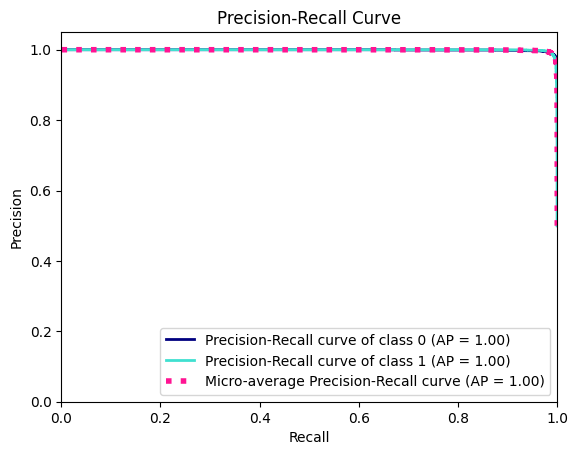

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle

# Assuming you have the predicted probabilities for each class
y_pred_prob = model.predict(X_test)  # Replace with your predicted probabilities
y_true = y_test  # Replace with your true labels

# Calculate the number of classes
num_classes = y_true.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])

# Compute micro-average precision and recall
precision_micro, recall_micro, _ = precision_recall_curve(y_true.ravel(), y_pred_prob.ravel())
average_precision_micro = average_precision_score(y_true, y_pred_prob, average='micro')

# Plot precision-recall curves for each class
plt.figure()
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

# Plot micro-average precision-recall curve
plt.plot(recall_micro, precision_micro, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall curve (AP = {0:0.2f})'.format(average_precision_micro))

# Set the plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.savefig('Models/METU/inception/precision_recall_curveinception.png')
plt.show()

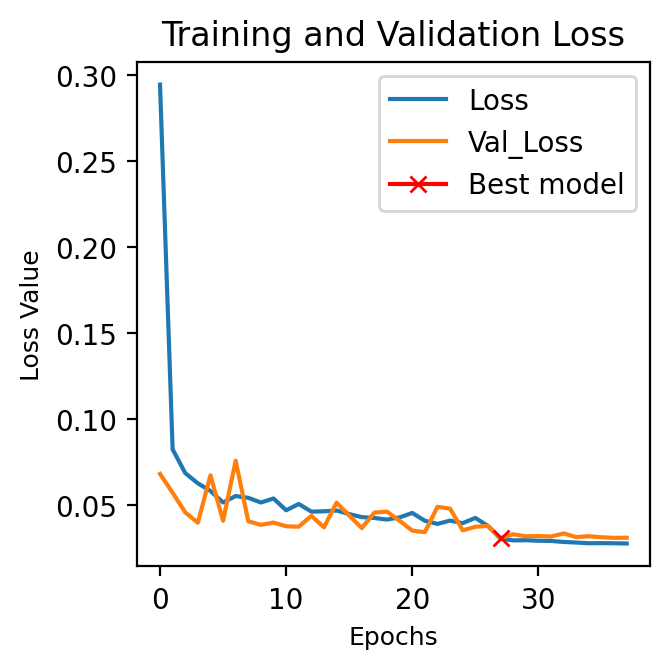

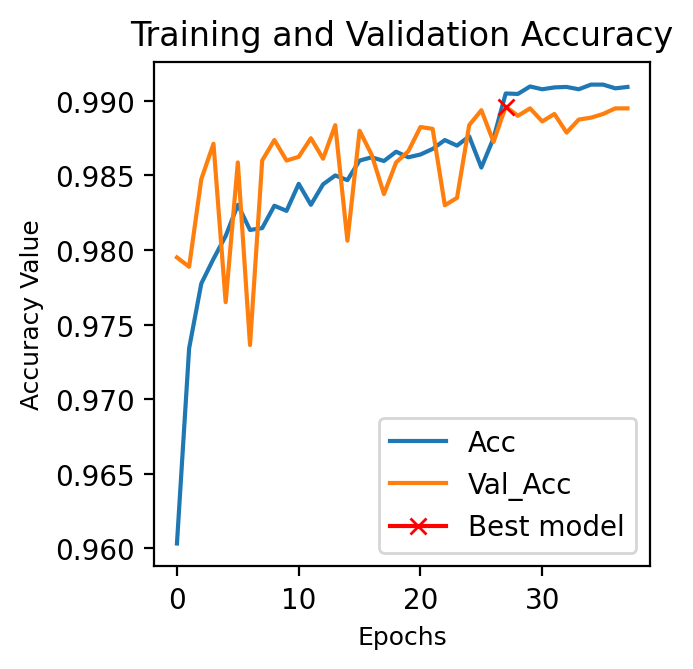

In [23]:
plt.figure(figsize=(1.15*3,1.15*3), dpi=200, edgecolor='black', facecolor='white', linewidth=0)
#plt.figure(figsize=(12,10))
#plt.subplot(1,2,1)
plt.title("Training and Validation Loss")
plt.plot(history_inception.history["loss"], label="Loss")
plt.plot(history_inception.history["val_loss"], label="Val_Loss")
plt.plot( np.argmin(history_inception.history["val_loss"]), np.min(history_inception.history["val_loss"]), marker="x", color="r", label="Best model")
plt.legend()
plt.xlabel("Epochs", fontsize=3*3, color='black')
plt.ylabel("Loss Value", fontsize=3*3, color='black')
plt.tight_layout()
plt.savefig("Models/METU/inception/Loss-C-LUinception", bbox_inches='tight', dpi=200)

#plt.subplot(1,2,2)
plt.figure(figsize=(1.15*3,1.15*3), dpi=200, edgecolor='black', facecolor='white', linewidth=0)
plt.title("Training and Validation Accuracy")
plt.plot(history_inception.history["accuracy"], label="Acc")
plt.plot(history_inception.history["val_accuracy"], label="Val_Acc")
plt.plot(np.argmax(history_inception.history["val_accuracy"]), np.max(history_inception.history["val_accuracy"]), marker="x", color="r", label="Best model")
plt.legend()
plt.xlabel("Epochs", fontsize=3*3, color='black')
plt.ylabel("Accuracy Value", fontsize=3*3, color='black')
plt.tight_layout()
plt.savefig("Models/METU/inception/Accu-C-Luinception", bbox_inches='tight', dpi=200)

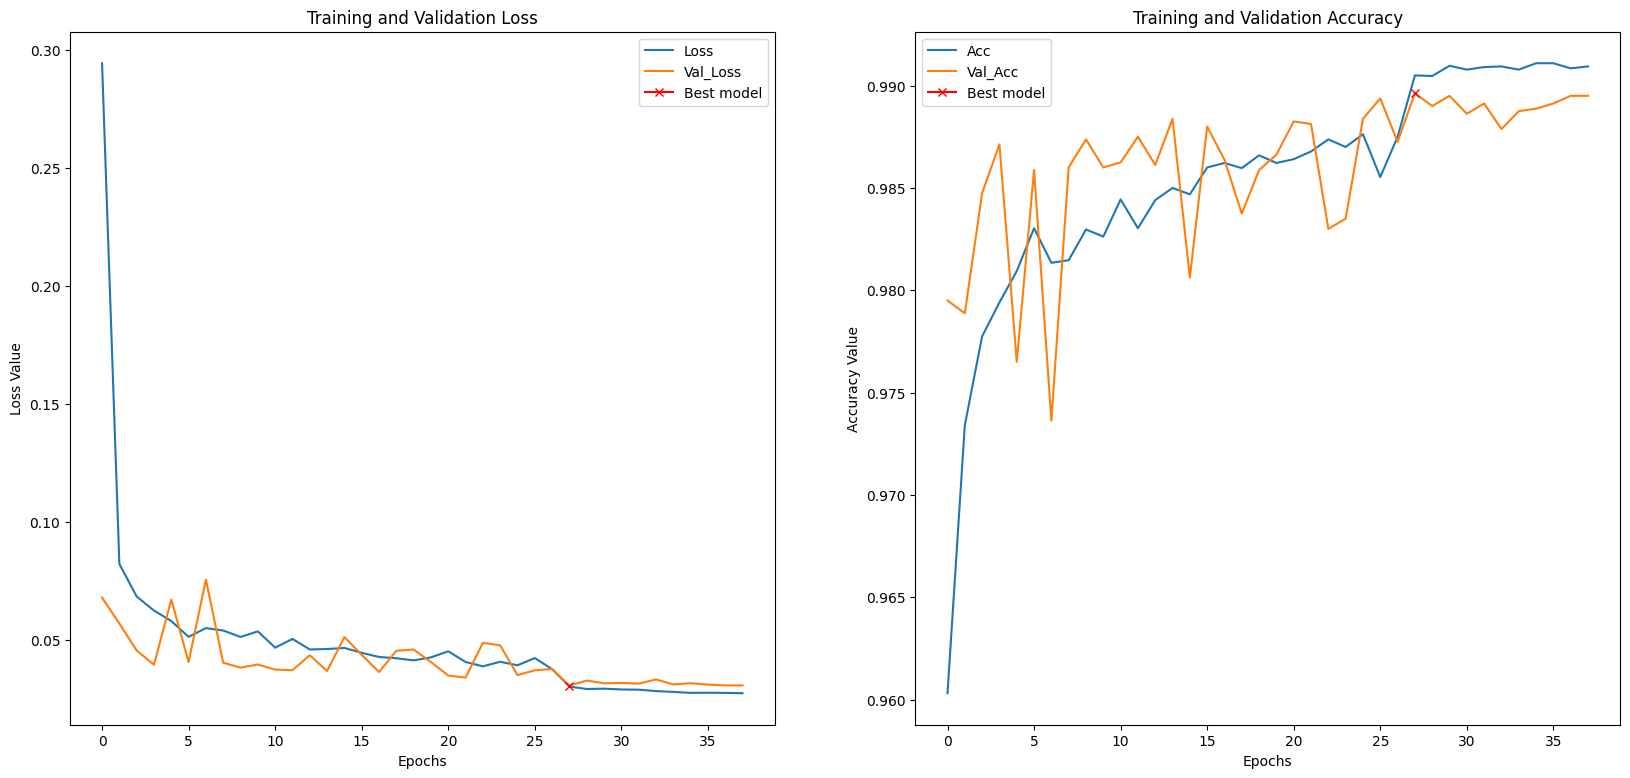

In [21]:
import matplotlib.pyplot as plt

# Plotting the Training and Validation Loss
plt.figure(figsize=(20, 9))
plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(history_inception.history["loss"], label="Loss")
plt.plot(history_inception.history["val_loss"], label="Val_Loss")
plt.plot(np.argmin(history_inception.history["val_loss"]), np.min(history_inception.history["val_loss"]), marker="x", color="r", label="Best model")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Value")

# Saving the Loss plot as an image
plt.savefig("Models/METU/inception/Loss-C-LU.png", bbox_inches='tight', dpi=200)

# Plotting the Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(history_inception.history["accuracy"], label="Acc")
plt.plot(history_inception.history["val_accuracy"], label="Val_Acc")
plt.plot(np.argmax(history_inception.history["val_accuracy"]), np.max(history_inception.history["val_accuracy"]), marker="x", color="r", label="Best model")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")

# Saving the Accuracy plot as an image
plt.savefig("Models/METU/inception/Accu-C-Lu.png", bbox_inches='tight', dpi=200)

# Displaying the plots
plt.show()